In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier

pd.set_option('display.max_columns',100)

In [2]:
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')

Porto Seguro는 브라질의 자동차 보험 회사입니다. 본 경진 대회의 목적은 어떤 차주가 내년에 보험 청구를 할 확률을 예측하는 겁니다.

데이터는 59만 개의 훈련 데이터와 89만 개의 테스트 데이터로 구성되어 있습니다. 테스트 데이터가 훈련 데이터보다 많습니다. 그리고 Null 값이 np.NaN이 아닌 -1로 되어있습니다. 또한, Feature가 무엇을 뜻하는지 제시하지 않았다는 것이 특징입니다. 보통은 특정 Feature가 무엇을 나타내는지 알려줍니다. 예를 들어 집 값을 예측하는 데이터에서 Feature 중 방 크기(Area)가 있습니다. 방 크기가 크면 집 값이 올라갈 것이라는 예상을 해볼 수 있습니다. 하지만 Porto Seguro 컴피티션에는 각 Feature가 무엇을 의미하는지 알 수 없습니다. 데이터를 안내한 부분에도 나와있지 않고, Feature의 이름으로 유추하기도 어렵습니다. 다만, Feature가 binary인지, categorical인지, oridnal인지, nominal인지만 구분할 수 있을 뿐입니다. 보안상 공개를 하지 않는 것 같습니다.

target은 보험 청구를 한다(=1), 보험 청구를 하지 않는다(=0)인 binary 데이터입니다. 0과 1로 구성되어 있으며 0이 1보다 압도적으로 많습니다.

## Data at first sight

Here is an excerpt of the the data description for the competition:

- Features that belong to <b>similar groupings are tagged</b> as such in the feature names (e.g., ind, reg, car, calc).
- Feature names include the postfix <b>bin</b> to indicate binary features and <b>cat</b> to indicate categorical features.
- Features <b>without these designations are either continuous or ordinal.</b>
- Values of <b>-1</b> indicate that the feature was <b>missing</b> from the observation.
- The <b>target</b> columns signifies whether or not a claim was filed for that policy holder.<br><br>
Ok, that's important information to get us started. Let's have a quick look at the first and last rows to confirm all of this.

In [3]:
train.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7,0.2,0.718070,10,1,-1,0,1,4,1,0,0,1,12,2,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8,0.4,0.766078,11,1,-1,0,-1,11,1,1,2,1,19,3,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.0,0.0,-1.000000,7,1,-1,0,-1,14,1,1,2,1,60,1,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1,2,2,9,1,8,2,7,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9,0.2,0.580948,7,1,0,0,1,11,1,1,3,1,104,1,0.374166,0.542949,0.294958,2.000000,0.6,0.9,0.1,2,4,7,1,8,4,2,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.7,0.6,0.840759,11,1,-1,0,-1,14,1,1,2,1,82,3,0.316070,0.565832,0.365103,2.000000,0.4,0.6,0.0,2,2,6,3,10,2,12,3,1,1,3,0,0,0,1,1,0


In [4]:
train.tail()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
595207,1488013,0,3,1,10,0,0,0,0,0,1,0,0,0,0,0,13,1,0,0,0.5,0.3,0.692820,10,1,-1,0,1,1,1,1,0,1,31,3,0.374166,0.684631,0.385487,2.645751,0.4,0.5,0.3,3,0,9,0,9,1,12,4,1,9,6,0,1,1,0,1,1
595208,1488016,0,5,1,3,0,0,0,0,0,1,0,0,0,0,0,6,1,0,0,0.9,0.7,1.382027,9,1,-1,0,-1,15,0,0,2,1,63,2,0.387298,0.972145,-1.000000,3.605551,0.2,0.2,0.0,2,4,8,6,8,2,12,4,1,3,8,1,0,1,0,1,1
595209,1488017,0,1,1,10,0,0,1,0,0,0,0,0,0,0,0,12,1,0,0,0.9,0.2,0.659071,7,1,-1,0,-1,1,1,1,2,1,31,3,0.397492,0.596373,0.398748,1.732051,0.4,0.0,0.3,3,2,7,4,8,0,10,3,2,2,6,0,0,1,0,0,0
595210,1488021,0,5,2,3,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.9,0.4,0.698212,11,1,-1,0,-1,11,1,1,2,1,101,3,0.374166,0.764434,0.384968,3.162278,0.0,0.7,0.0,4,0,9,4,9,2,11,4,1,4,2,0,1,1,1,0,0
595211,1488027,0,0,1,8,0,0,1,0,0,0,0,0,0,0,0,7,1,0,0,0.1,0.2,-1.000000,7,0,-1,0,-1,0,1,0,2,1,34,2,0.400000,0.932649,0.378021,3.741657,0.4,0.0,0.5,2,3,10,4,10,2,5,4,4,3,8,0,1,0,0,0,0


In [5]:
train.shape

(595212, 59)

In [6]:
# 중복값 처리
train.drop_duplicates()
train.shape # 중복값 없음

(595212, 59)

In [7]:
test.shape

(892816, 58)

We are missing one variable in the test set, but this is the target variable. So that's fine.
Let's now invesigate how many variables of each type we have.

So later on we can create dummy variables for the 14 categorical variables. The bin variables are already binary and do not need dummification.

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 59 columns):
id                595212 non-null int64
target            595212 non-null int64
ps_ind_01         595212 non-null int64
ps_ind_02_cat     595212 non-null int64
ps_ind_03         595212 non-null int64
ps_ind_04_cat     595212 non-null int64
ps_ind_05_cat     595212 non-null int64
ps_ind_06_bin     595212 non-null int64
ps_ind_07_bin     595212 non-null int64
ps_ind_08_bin     595212 non-null int64
ps_ind_09_bin     595212 non-null int64
ps_ind_10_bin     595212 non-null int64
ps_ind_11_bin     595212 non-null int64
ps_ind_12_bin     595212 non-null int64
ps_ind_13_bin     595212 non-null int64
ps_ind_14         595212 non-null int64
ps_ind_15         595212 non-null int64
ps_ind_16_bin     595212 non-null int64
ps_ind_17_bin     595212 non-null int64
ps_ind_18_bin     595212 non-null int64
ps_reg_01         595212 non-null float64
ps_reg_02         595212 non-null float64
ps_re

## Metadata

To facilitate the data management, we'll store meta-information about the variables in a DataFrame. This will be helpful when we want to select specific variables for analysis, visualization, modeling, ...

Concretely we will store:<br><br>
- <b>role</b> : input, ID, target
- <b>level</b> : nominal, interval, oridnal, binary
- <b>keep</b> : True or False
- <b>dtype</b> : int, float, str

 ㅇ 데이터에 대한 데이터로써 하위레벨의 데이터를 설명/기술하려는 것
     - 상위레벨에서 하위레벨 데이터에 대한 각종 정보(자원의 속성)를 담고있는 데이터
     - 설명/기술 例) 문서 유형, 문서 구조, 문서 길이, 문서 작성자, 문서 작성일 등

  ㅇ 즉, 자료 그 자체가 아닌 자료의 속성 등을 설명하는 데이터
     - 속성 例) 데이터에 관한 정보의 기술, 데이터 구성의 정의, 데이터의 분류 등을 위한 데이터 등

In [9]:
train.ps_car_09_cat.dtype

dtype('int64')

In [10]:
data = []
for f in train.columns:
    # Defining the role
    if f == 'target':
        role = 'target'
    elif f == 'id':
        role = 'id'
    else:
        role = 'input'
         
    # Defining the level
    if 'bin' in f or f == 'target':
        level = 'binary'
    elif 'cat' in f or f == 'id':
        level = 'nominal'
    elif train[f].dtype == "float64":
        level = 'interval'
    elif train[f].dtype == "int64":
        level = 'ordinal'
        
    # Initialize keep to True for all variables except for id
    keep = True
    if f == 'id':
        keep = False
    
    # Defining the data type 
    dtype = train[f].dtype
    
    # Creating a Dict that contains all the metadata for the variable
    f_dict = {
        'varname': f,
        'role': role,
        'level': level,
        'keep': keep,
        'dtype': dtype
    }
    data.append(f_dict)
    
meta = pd.DataFrame(data, columns=['varname', 'role', 'level', 'keep', 'dtype'])
meta.set_index('varname', inplace=True)

In [11]:
meta

,role,level,keep,dtype
varname,,,,
id,id,nominal,False,int64
target,target,binary,True,int64
ps_ind_01,input,ordinal,True,int64
ps_ind_02_cat,input,nominal,True,int64
ps_ind_03,input,ordinal,True,int64
ps_ind_04_cat,input,nominal,True,int64
ps_ind_05_cat,input,nominal,True,int64
ps_ind_06_bin,input,binary,True,int64
ps_ind_07_bin,input,binary,True,int64


Example to extract all nominal variables that are not dropped

In [12]:
meta[(meta.level == 'nominal') & (meta.keep)].index

Index(['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat',
       'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat',
       'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat',
       'ps_car_10_cat', 'ps_car_11_cat'],
      dtype='object', name='varname')

In [13]:
pd.DataFrame({'count' : meta.groupby(['role','level'])['role'].size()}).reset_index()

,role,level,count
0,id,nominal,1
1,input,binary,17
2,input,interval,10
3,input,nominal,14
4,input,ordinal,16
5,target,binary,1


<h2>Descriptive statistics</h2>
We can also apply the describe method on the dataframe. However, it doesn't make much sense to calculate the mean, std, ... on categorical variables and the id variable. We'll explore the categorical variables visually later.

Thanks to our meta file we can easily select the variables on which we want to compute the descriptive statistics. To keep things clear, we'll do this per data type.

##### interval variables

In [14]:
v = meta[(meta.level == 'interval') & (meta.keep)].index
train[v].describe()

,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.610991,0.439184,0.551102,0.379945,0.813265,0.276256,3.065899,0.449756,0.449589,0.449849
std,0.287643,0.404264,0.793506,0.058327,0.224588,0.357154,0.731366,0.287198,0.286893,0.287153
min,0.000000,0.000000,-1.000000,-1.000000,0.250619,-1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.400000,0.200000,0.525000,0.316228,0.670867,0.333167,2.828427,0.200000,0.200000,0.200000
50%,0.700000,0.300000,0.720677,0.374166,0.765811,0.368782,3.316625,0.500000,0.400000,0.500000
75%,0.900000,0.600000,1.000000,0.400000,0.906190,0.396485,3.605551,0.700000,0.700000,0.700000
max,0.900000,1.800000,4.037945,1.264911,3.720626,0.636396,3.741657,0.900000,0.900000,0.900000


참고 : 구간 나누기 함수 : https://rfriend.tistory.com/521

<b>reg variables</b>
- only ps_reg_03 has missing values
- the range (min to max) differs between the variables. We could apply scaling (e.g. StandardScaler), but it depends on the classifier we will want to use.
<br>

<b>car variables</b>
- ps_car_12 and ps_car_15 have missing values
- again, the range differs and we could apply scaling.

<b>calc variables</b>
- no missing values
- this seems to be some kind of ratio as the maximum is 0.9
- all three _calc variables have very similar distributions

<b>Overall</b>, we can see that the range of the interval variables is rather small. Perhaps some transformation (e.g. log) is already applied in order to anonymize the data?

##### oridinal variables

In [15]:
v = meta[(meta.level == 'ordinal') & (meta.keep)].index
train[v].describe()

,ps_ind_01,ps_ind_03,ps_ind_14,ps_ind_15,ps_car_11,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,1.900378,4.423318,0.012451,7.299922,2.346072,2.372081,1.885886,7.689445,3.005823,9.225904,2.339034,8.433590,5.441382,1.441918,2.872288,7.539026
std,1.983789,2.699902,0.127545,3.546042,0.832548,1.117219,1.134927,1.334312,1.414564,1.459672,1.246949,2.904597,2.332871,1.202963,1.694887,2.746652
min,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,5.000000,2.000000,2.000000,1.000000,7.000000,2.000000,8.000000,1.000000,6.000000,4.000000,1.000000,2.000000,6.000000
50%,1.000000,4.000000,0.000000,7.000000,3.000000,2.000000,2.000000,8.000000,3.000000,9.000000,2.000000,8.000000,5.000000,1.000000,3.000000,7.000000
75%,3.000000,6.000000,0.000000,10.000000,3.000000,3.000000,3.000000,9.000000,4.000000,10.000000,3.000000,10.000000,7.000000,2.000000,4.000000,9.000000
max,7.000000,11.000000,4.000000,13.000000,3.000000,5.000000,6.000000,10.000000,9.000000,12.000000,7.000000,25.000000,19.000000,10.000000,13.000000,23.000000


Only one missing variable: ps_car_11
We could apply scaling to deal with the different ranges

##### Binary variables

In [16]:
v = meta[(meta.level == 'binary') & (meta.keep)].index
train[v].describe()

,target,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.036448,0.393742,0.257033,0.163921,0.185304,0.000373,0.001692,0.009439,0.000948,0.660823,0.121081,0.153446,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,0.187401,0.488579,0.436998,0.370205,0.388544,0.019309,0.041097,0.096693,0.030768,0.473430,0.326222,0.360417,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


A priori in the train data is 3.645%, which is strongly imbalanced.
From the means we can conclude that for most variables the value is zero in most cases.

A priori의 의미 : 선험적 <br>
참고자료 : https://blog.naver.com/cock25king/221988138585

<h2>Handling imbalanced classes</h2>
As we mentioned above the proportion of records with target=1 is far less than target=0. This can lead to a model that has great accuracy but does have any added value in practice. Two possible strategies to deal with this problem are:

- oversampling records with target=1
- undersampling records with target=0

There are many more strategies of course and MachineLearningMastery.com gives a nice overview. As we have a rather large training set, we can go for undersampling.

In [17]:
desired_apriori=0.10

# Get the indices per target value
idx_0 = train[train.target == 0].index
idx_1 = train[train.target == 1].index

# Get original number of records per target value
nb_0 = len(train.loc[idx_0])
nb_1 = len(train.loc[idx_1])

# Calculate the undersampling rate and resulting number of records with target=0
undersampling_rate = ((1-desired_apriori)*nb_1)/(nb_0*desired_apriori)
undersampled_nb_0 = int(undersampling_rate*nb_0)
print('Rate to undersample records with target=0: {}'.format(undersampling_rate))
print('Number of records with target=0 after undersampling: {}'.format(undersampled_nb_0))

# Randomly select records with target=0 to get at the desired a priori
undersampled_idx = shuffle(idx_0, random_state=37, n_samples=undersampled_nb_0)

# Construct list with remaining indices
idx_list = list(undersampled_idx) + list(idx_1)

# Return undersample data frame
train = train.loc[idx_list].reset_index(drop=True)

Rate to undersample records with target=0: 0.34043569687437886
Number of records with target=0 after undersampling: 195246


##### Data Quality Checks

##### Checking missing values
Missings are represents as -1

In [18]:
vars_with_missing = []

for f in train.columns:
    missings = train[train[f] == -1][f].count()
    if missings >0 :
        vars_with_missing.append(f)
        missings_perc = missings / train.shape[0]
        
        print('Variable {} has {} records ({:.2%}) with missing values'.format(f,missings,missings_perc))
        
print('In total, there are {} variables with missing values'.format(len(vars_with_missing)))

Variable ps_ind_02_cat has 103 records (0.05%) with missing values
Variable ps_ind_04_cat has 51 records (0.02%) with missing values
Variable ps_ind_05_cat has 2256 records (1.04%) with missing values
Variable ps_reg_03 has 38580 records (17.78%) with missing values
Variable ps_car_01_cat has 62 records (0.03%) with missing values
Variable ps_car_02_cat has 2 records (0.00%) with missing values
Variable ps_car_03_cat has 148367 records (68.39%) with missing values
Variable ps_car_05_cat has 96026 records (44.26%) with missing values
Variable ps_car_07_cat has 4431 records (2.04%) with missing values
Variable ps_car_09_cat has 230 records (0.11%) with missing values
Variable ps_car_11 has 1 records (0.00%) with missing values
Variable ps_car_14 has 15726 records (7.25%) with missing values
In total, there are 12 variables with missing values


- <b>ps_car_03_cat and ps_car_05_cat</b> have a large proportion of records with missing values. Remove these variables.
- For the other categorical variables with missing values, we can leave the missing value -1 as such.
- <b>ps_reg_03 (continuous)</b> has missing values for 18% of all records. Replace by the mean.
- <b>ps_car_11 (ordinal)</b> has only 5 records with misisng values. Replace by the mode.
- <b>ps_car_12 (continuous)</b> has only 1 records with missing value. Replace by the mean.
- <b>ps_car_14 (continuous)</b> has missing values for 7% of all records. Replace by the mean.


In [19]:
# Dropping the variables with too many missing values
vars_to_drop = ['ps_car_03_cat','ps_car_05_cat']
train.drop(vars_to_drop,inplace = True,axis = 1)
meta.loc[(vars_to_drop),'keep'] = False # Updating the meta

In [20]:
# Imputing with the mean or mode
mean_imp = Imputer(missing_values = -1,strategy = 'mean',axis = 0)
mode_imp = Imputer(missing_values = -1,strategy = 'most_frequent',axis = 0)

# Class Imputer is deprecated; Imputer was deprecated in version 0.20 
# and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.

C:\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [21]:
train['ps_reg_03'] = mean_imp.fit_transform(train[['ps_reg_03']]).ravel()
train['ps_car_12'] = mean_imp.fit_transform(train[['ps_car_12']]).ravel()
train['ps_car_14'] = mean_imp.fit_transform(train[['ps_car_14']]).ravel()
train['ps_car_11'] = mode_imp.fit_transform(train[['ps_car_11']]).ravel()

<h3>Checking the cardinality of the categorical variables</h3>
Cardinality refers to the number of different values in a variable. As we will create dummy variables from the categorical variables later on, we need to check whether there are variables with many distinct values. We should handle these variables differently as they would result in many dummy variables.

In [22]:
v = meta[(meta.level == 'nominal') & (meta.keep)].index

for f in v:
    dist_values = train[f].value_counts().shape[0]
    print('Variable {} has {} distinct values'.format(f,dist_values))

Variable ps_ind_02_cat has 5 distinct values
Variable ps_ind_04_cat has 3 distinct values
Variable ps_ind_05_cat has 8 distinct values
Variable ps_car_01_cat has 13 distinct values
Variable ps_car_02_cat has 3 distinct values
Variable ps_car_04_cat has 10 distinct values
Variable ps_car_06_cat has 18 distinct values
Variable ps_car_07_cat has 3 distinct values
Variable ps_car_08_cat has 2 distinct values
Variable ps_car_09_cat has 6 distinct values
Variable ps_car_10_cat has 3 distinct values
Variable ps_car_11_cat has 104 distinct values


Only ps_car_11_cat has many distinct values, although it is still reasonable.

EDIT: nickycan made an excellent remark on the fact that my first solution could lead to data leakage. He also pointed me to another kernel made by oliver which deals with that. I therefore replaced this part with the kernel of oliver. All credits go to him. It is so great what you can learn by participating in the Kaggle competitions :)

In [23]:
def add_noise(series,noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))

def target_encode(trn_series = None, tst_series = None,target = None,min_samples_leaf = 1,
                 smoothing = 1, noise_level = 0):
    """
    Smoothing is computed like in the following paper by Daniele Micci-Barreca
    
    trn_series : training categorical feature as a pd.Series
    tst_series : test categorical feature as a pd.Series
    target : target data as a pd.Series
    min_samples_leaf (int) : minimum samples to take category average into account
    smoothing (int) : smoothing effect to balance categorical average vs prior  
    """
    
    
    assert len(trn_series) == len(target)
    assert trn_series.name == tst_series.name
    
    temp = pd.concat([trn_series,target],axis = 1)
    
    # Compute target mean
    averages = temp.groupby(by = trn_series.name)[target.name].agg(["mean","count"])
    
    # Compute smoothing
    smoothing = 1/(1 + np.exp(-(averages['count'] - min_samples_leaf)/smoothing))
    
    # Apply average function to all target data
    prior = target.mean()
    
    # the bigger the count the less full_avg is taken into account
    averages[target.name] = prior*(1-smoothing) + averages['mean']*smoothing
    averages.drop(['mean','count'],axis = 1,inplace = True)
    
    # Apply averages to trn and tst series
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns = {'index' : target.name,target.name : 'average'}),
        on = trn_series.name,
        how = 'left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    
    
    # pd.merge dose not keep the index so restore it
    ft_trn_series.index= trn_series.index
    ft_tst_series = pd.merge(
        tst_series.to_frame(tst_series.name),
        averages.reset_index().rename(columns = {'index' : target.name,target.name : "average"}),
        on = tst_series.name,
        how = 'left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    
    
    # pd.merge dose not keep the index so restore it
    ft_tst_series.index = tst_series.index
    return add_noise(ft_trn_series,noise_level),add_noise(ft_tst_series,noise_level)

In [24]:
train_encoded, test_encoded = target_encode(train['ps_car_11_cat'],test['ps_car_11_cat'],target = train.target,
                                           min_samples_leaf = 100,
                                           smoothing = 10,
                                           noise_level = 0.01)

train['ps_car_11_cat_te'] =  train_encoded
train.drop('ps_car_11_cat',axis = 1,inplace = True)
meta.loc['ps_car_11_cat','keep'] = False # updating the meta
test['ps_car_11_cat_te'] = test_encoded
test.drop('ps_car_11_cat',axis = 1,inplace = True)

## Exploratiory Data Visualization

<h5> Categorical variables</h5>
Let's look into the categorical variables and the proportion of customers with target = 1

In [25]:
A = pd.DataFrame(np.array([1,2,3,4,5,6,7,8,9]).reshape(3,3),columns = ['a','b','c'])

In [26]:
A.groupby('a',as_index = False).mean()

,a,b,c
0,1,2,3
1,4,5,6
2,7,8,9


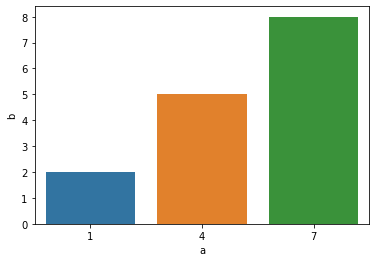

In [27]:
sns.barplot(x = 'a',y = 'b',data = A)

plt.tick_params표현
https://codetorial.net/matplotlib/set_grid_and_tick.html

<Figure size 432x288 with 0 Axes>

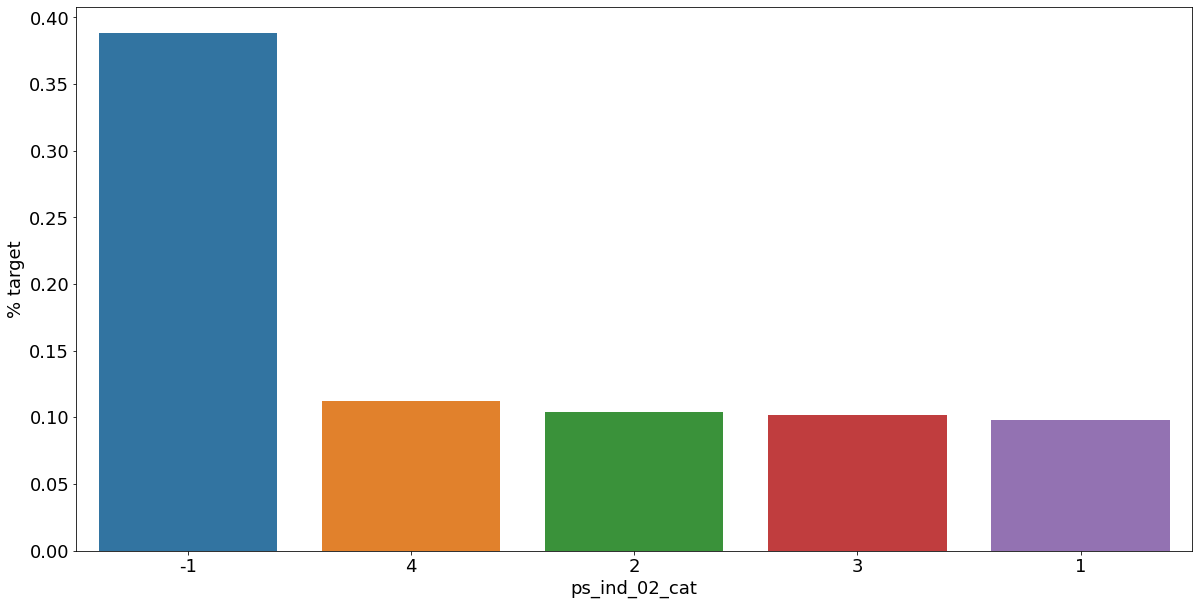

<Figure size 432x288 with 0 Axes>

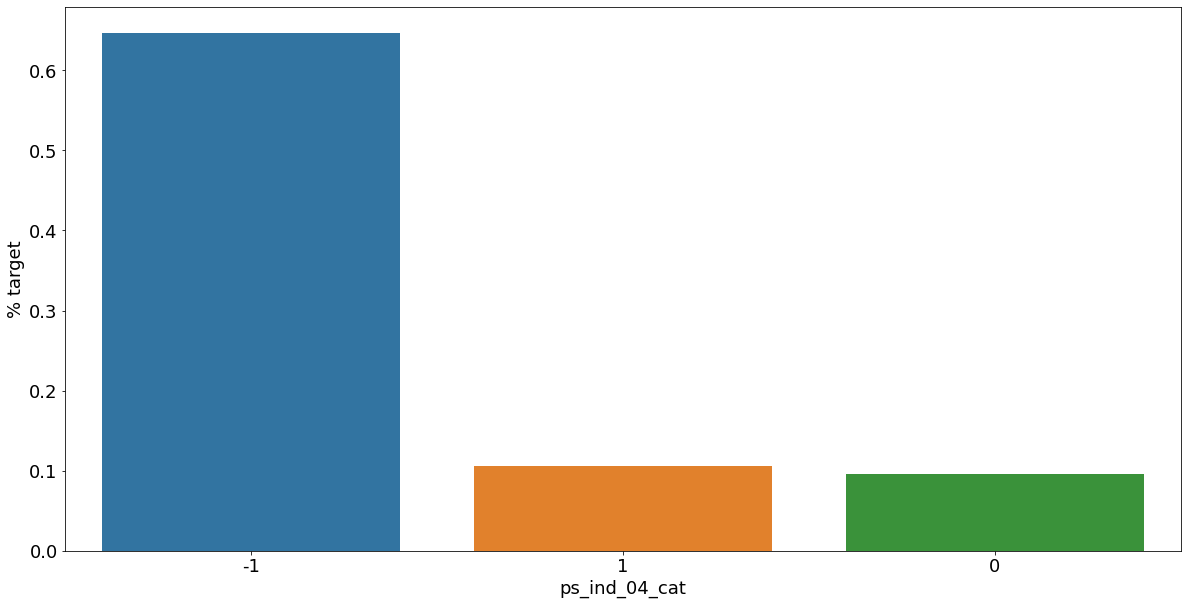

<Figure size 432x288 with 0 Axes>

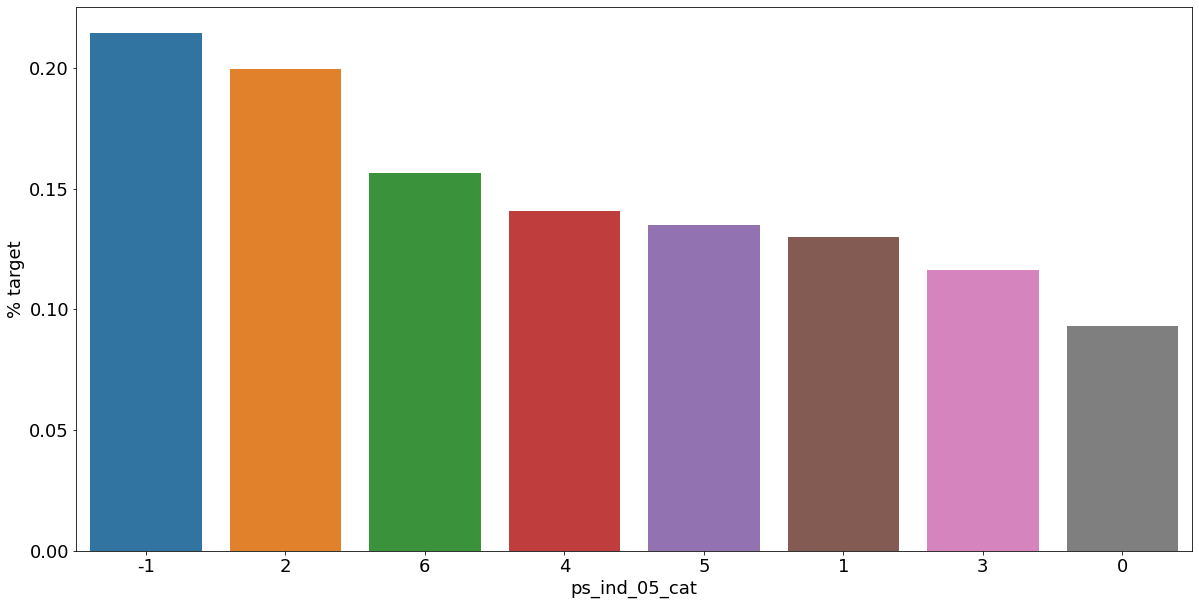

<Figure size 432x288 with 0 Axes>

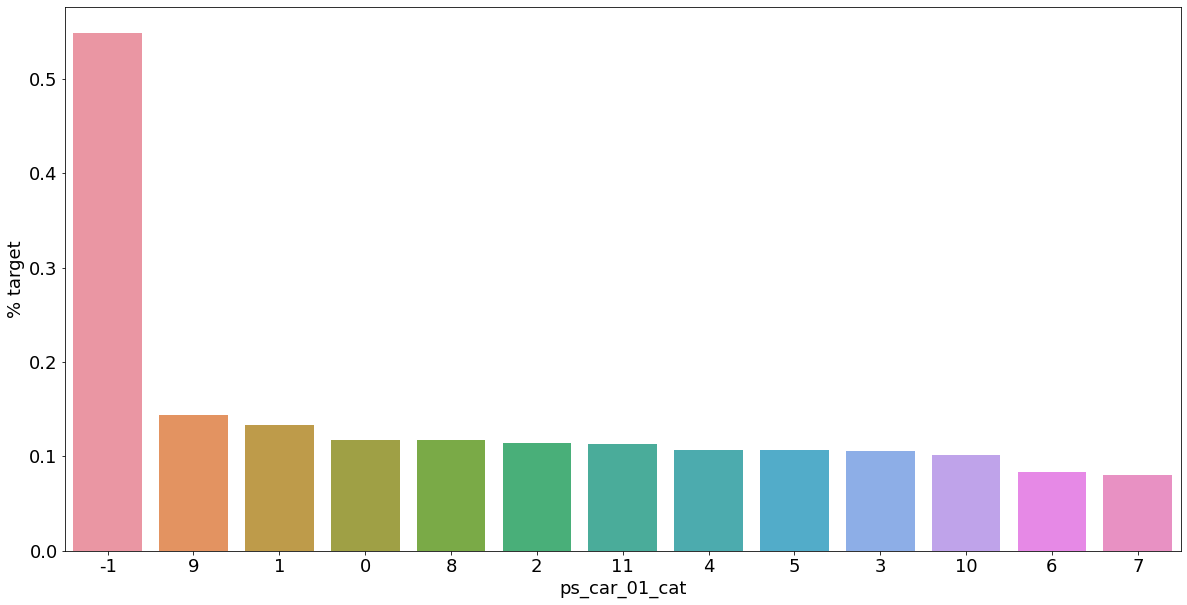

<Figure size 432x288 with 0 Axes>

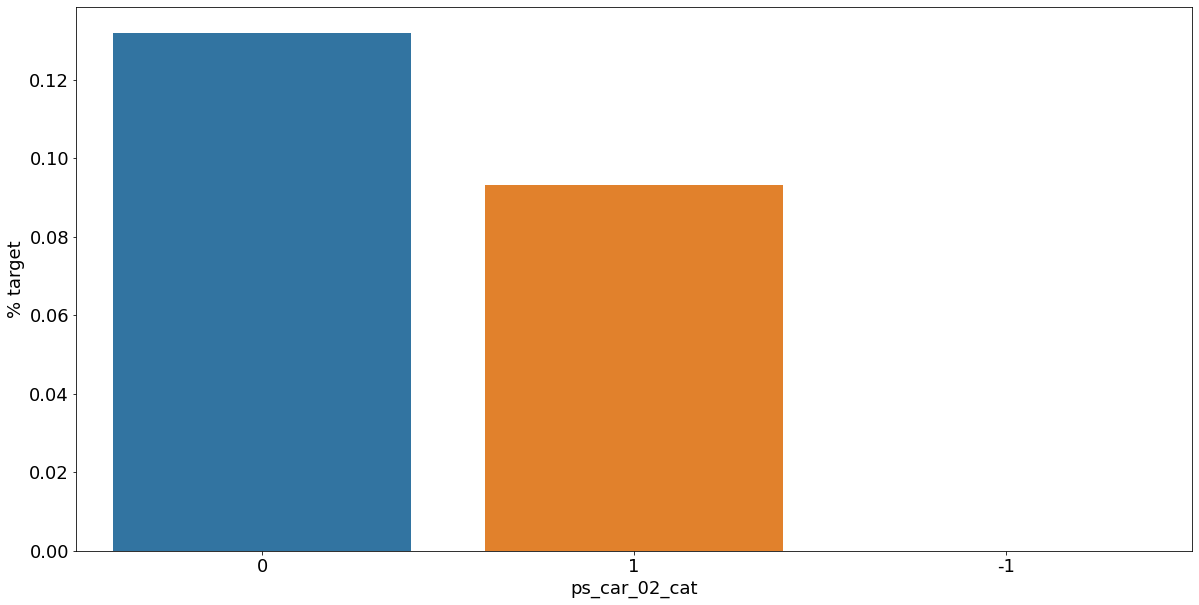

<Figure size 432x288 with 0 Axes>

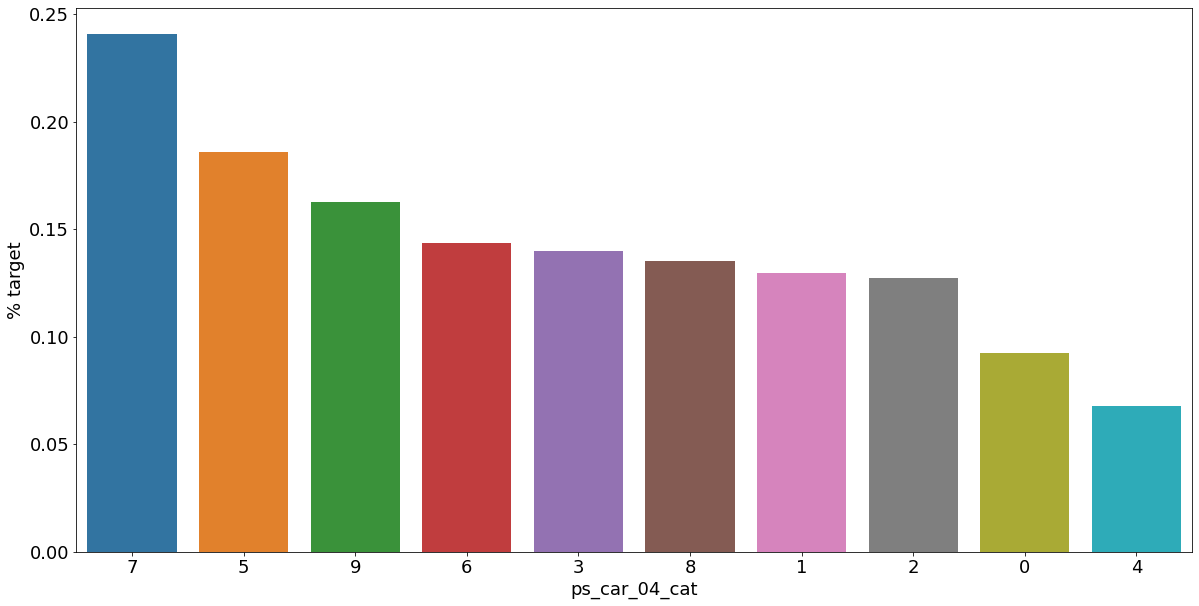

<Figure size 432x288 with 0 Axes>

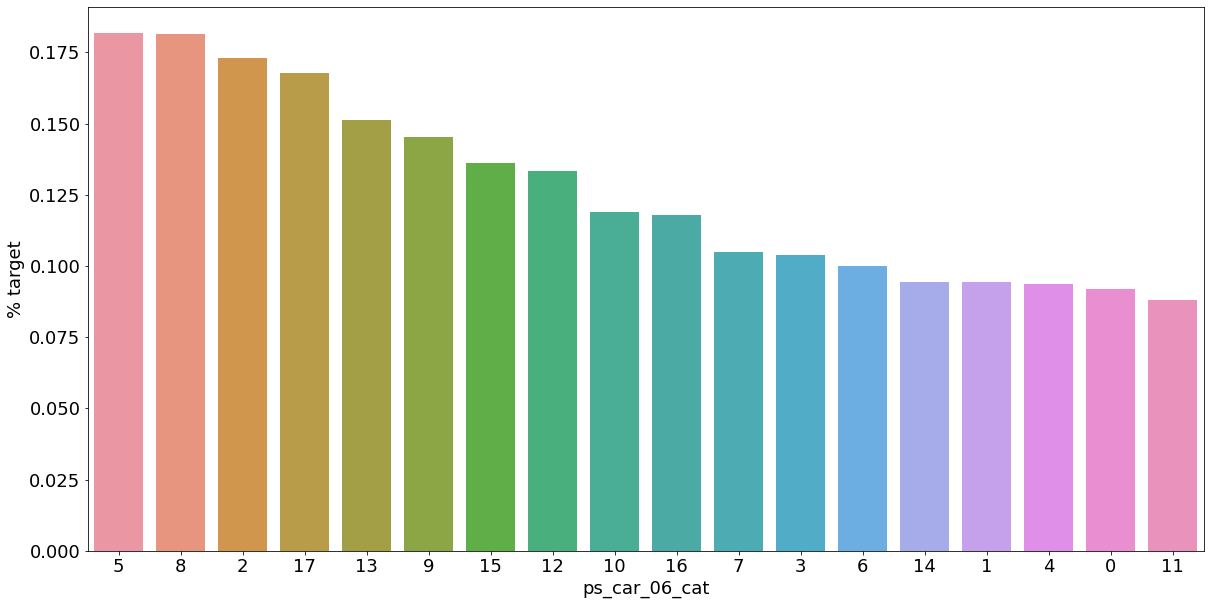

<Figure size 432x288 with 0 Axes>

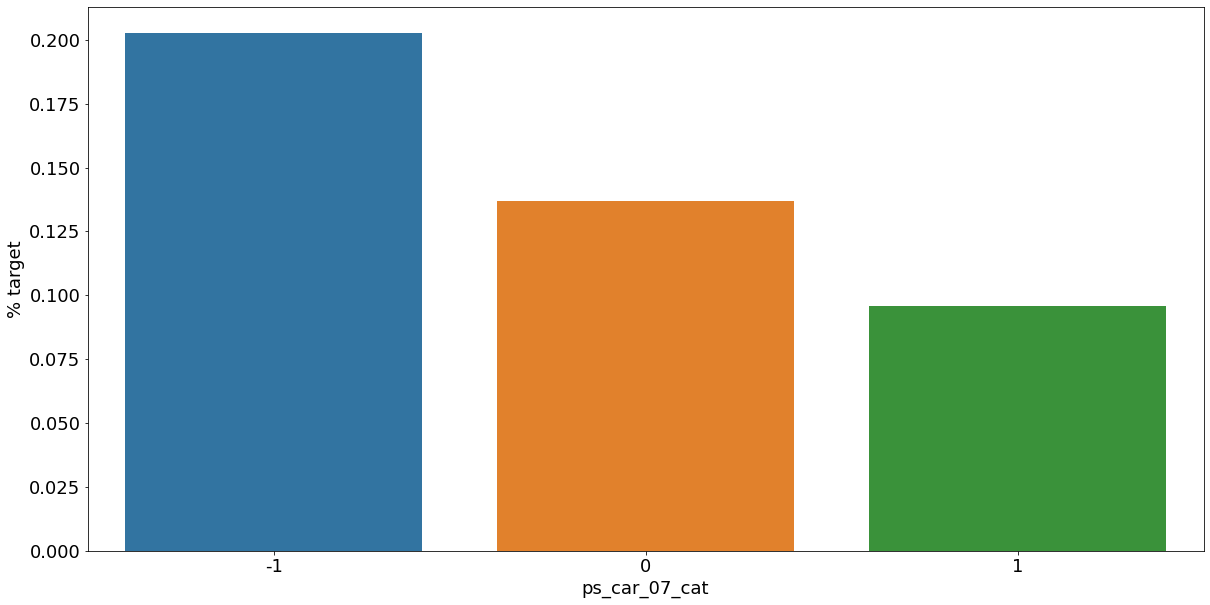

<Figure size 432x288 with 0 Axes>

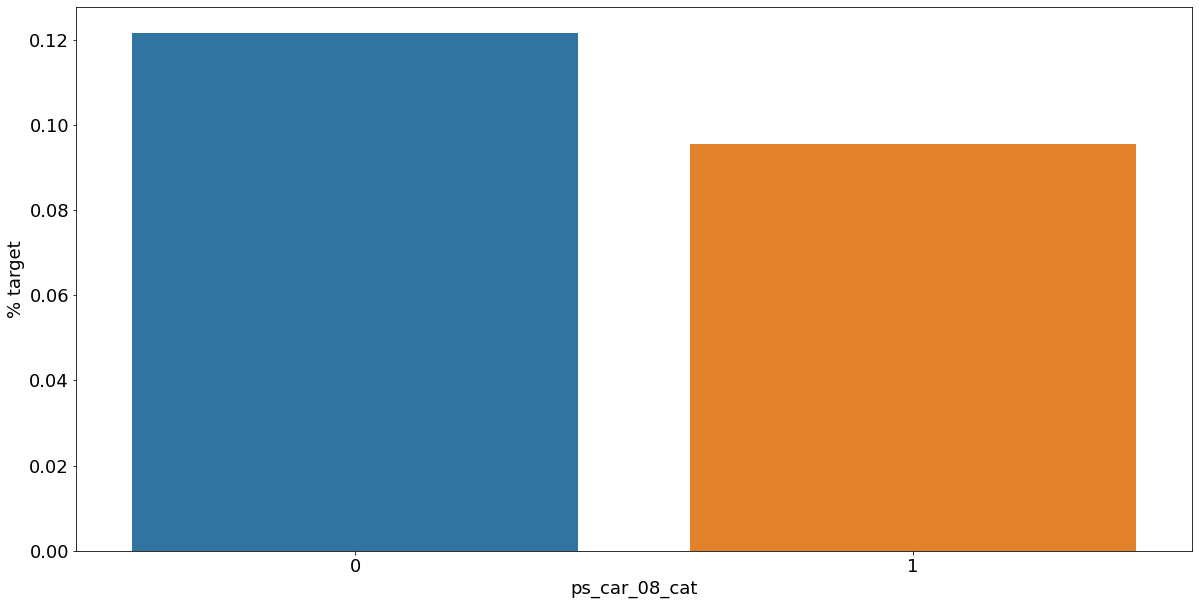

<Figure size 432x288 with 0 Axes>

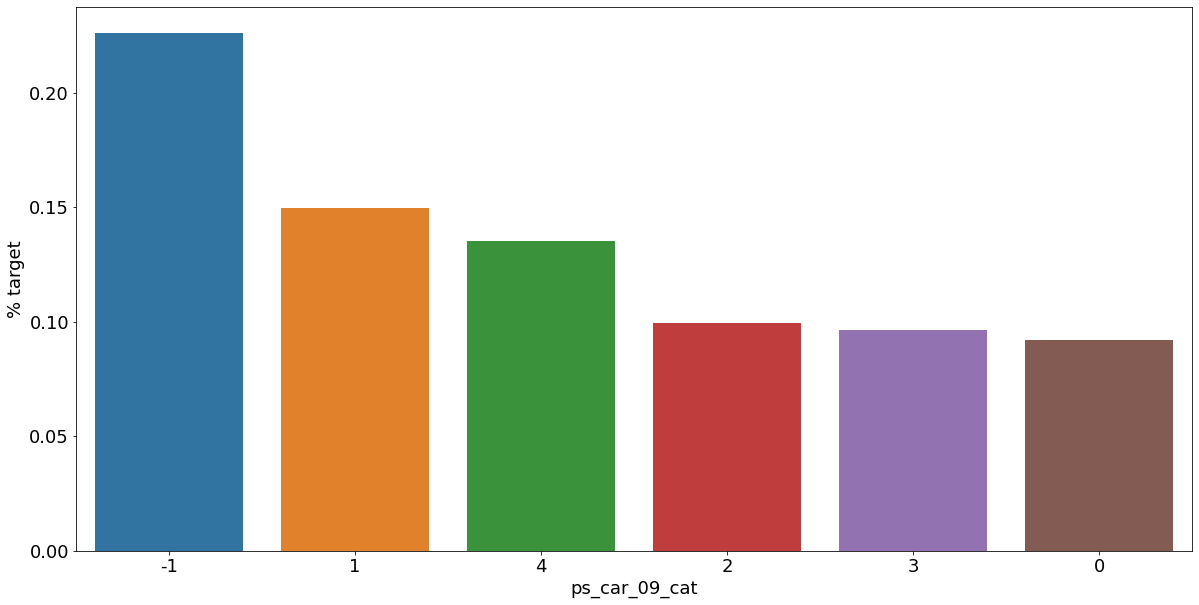

<Figure size 432x288 with 0 Axes>

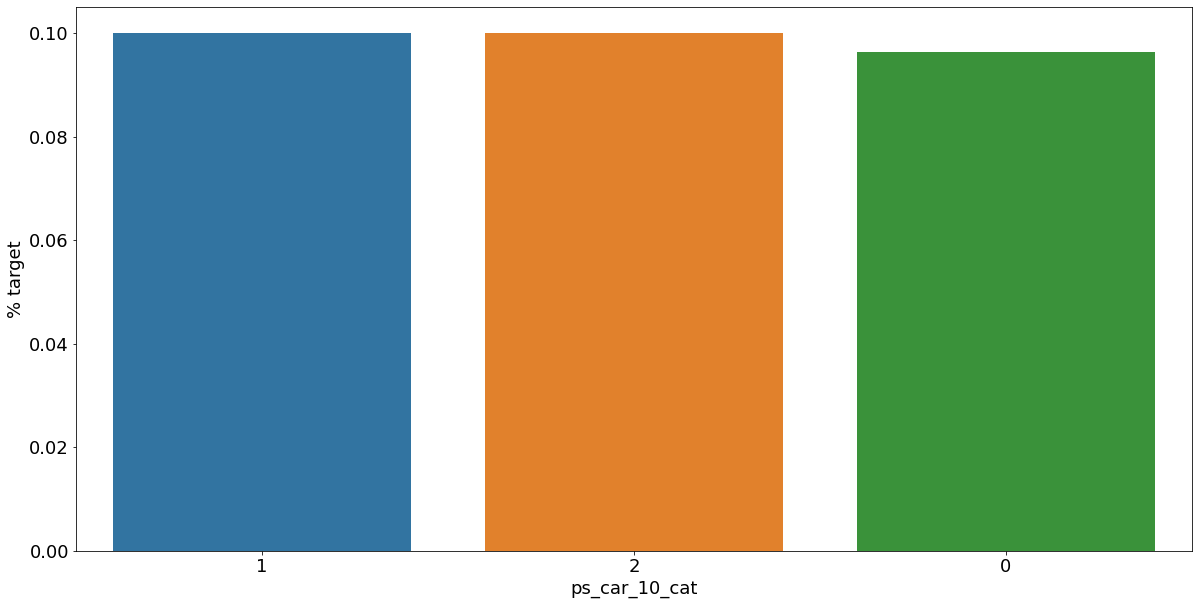

In [28]:
v = meta[(meta.level == 'nominal')  & (meta.keep)].index

for f in v:
    plt.figure()
    fig, ax = plt.subplots(figsize = (20,10))
    
    # Calculate the percentage of target = 1 per category value
    cat_perc = train[[f,'target']].groupby([f],as_index = False).mean()
    cat_perc.sort_values(by = 'target',ascending = False,inplace = True)
    
    # Barplot
    # Order the bars descending on target mean
    sns.barplot(ax = ax,x = f,y = 'target',data = cat_perc,order = cat_perc[f])
    plt.ylabel('% target',fontsize = 18)
    plt.xlabel(f,fontsize = 18)
    plt.tick_params(axis = 'both',which = 'major',labelsize = 18)
    plt.show()

As we can see from the variables with missing values, it is a good idea to keep the missing values as a separate category value, instead of replacing them by the mode for instance. The customers with a missing value appear to have a much higher (in some cases much lower) probability to ask for an insurance claim.

<h3>Interval variables</h3>
Checking the correlations between interval variables. A heatmap is a good way to visualize the correlation between variables. The code below is based on an example by Michael Waskom

In [29]:
cmap = sns.diverging_palette(220,10,as_cmap = True)
cmap

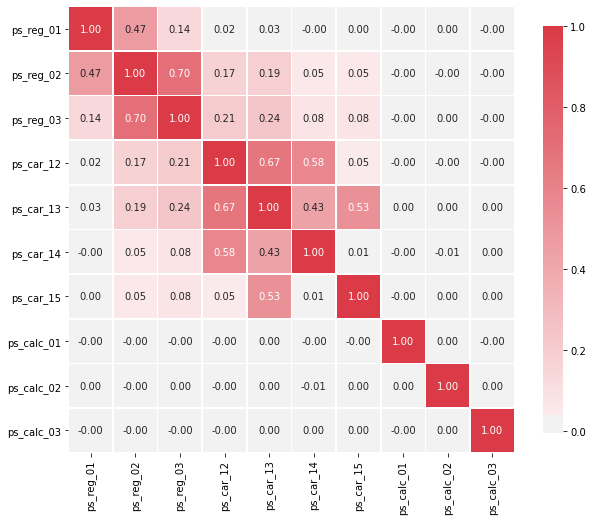

In [30]:
def corr_heatmap(v):
    correlations = train[v].corr()
    
    # Create color map ranging between two colors
    cmap = sns.diverging_palette(220,10,as_cmap = True)
    
    fig,ax = plt.subplots(figsize = (10,10))
    sns.heatmap(correlations,cmap = cmap,vmax = 1.0,center = 0,fmt = '.2f',
               square = True,linewidths = .5,annot = True,cbar_kws = {'shrink' : .75})
    plt.show()
v = meta[(meta.level == 'interval') & (meta.keep)].index
corr_heatmap(v)

There are a strong correlations between the variables:

- ps_reg_02 and ps_reg_03 (0.7)
- ps_car_12 and ps_car13 (0.67)
- ps_car_12 and ps_car14 (0.58)
- ps_car_13 and ps_car15 (0.53)<br>

Seaborn has some handy plots to visualize the (linear) relationship between variables. We could use a pairplot to visualize the relationship between the variables. But because the heatmap already showed the limited number of correlated variables, we'll look at each of the highly correlated variables separately.
<br> <h4>NOTE: I take a sample of the train data to speed up the process.</h4>

In [31]:
s = train.sample(frac = 0.1)

<h2>ps_reg_02 and ps_reg_03</h2>
    
<br>

As the regression line shows, there is a linear relationship between these variables. Thanks to the hue parameter we can see that the regression lines for target=0 and target=1 are the same.



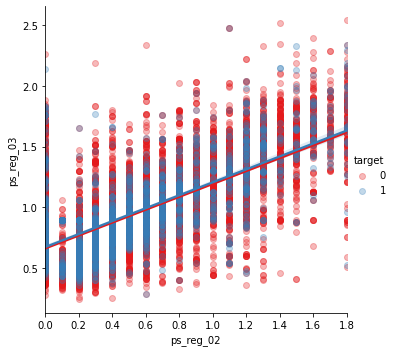

In [34]:
sns.lmplot(x = 'ps_reg_02',y = 'ps_reg_03',data = s, hue = 'target',palette = 'Set1',scatter_kws = {'alpha' : 0.3})
plt.show()

##### ps_car_12 and ps_car_13

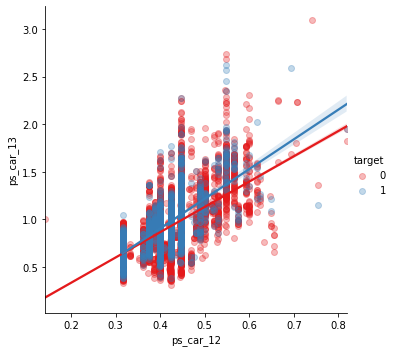

In [35]:
sns.lmplot(x = 'ps_car_12',y = 'ps_car_13',data =s , hue = 'target', palette="Set1",scatter_kws = {'alpha':0.3})
plt.show()

##### ps_car_12 and ps_car_14

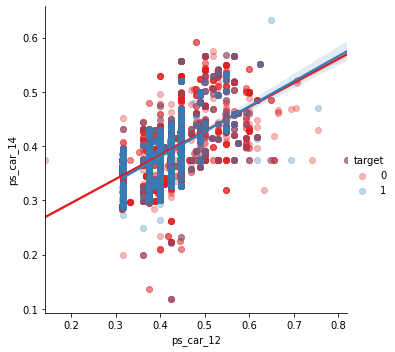

In [37]:
sns.lmplot(x = 'ps_car_12',y = 'ps_car_14',data = s ,hue = 'target',palette = 'Set1',scatter_kws = {"alpha" : 0.3})
plt.show()

##### ps_car_13 and ps_car_15

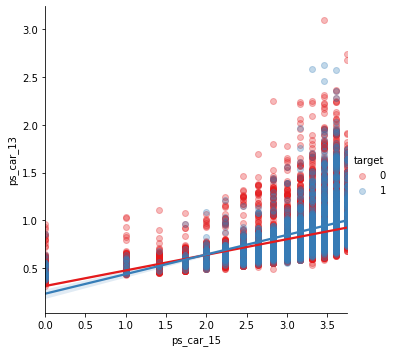

In [38]:
sns.lmplot(x = 'ps_car_15',y = 'ps_car_13',data = s,hue = 'target',palette = "Set1",scatter_kws = {'alpha':0.3})
plt.show()

Allright, so now what? How can we decide which of the correlated variables to keep? We could perform Principal Component Analysis (PCA) on the variables to reduce the dimensions. In the AllState Claims Severity Competition I made this kernel to do that. But as the number of correlated variables is rather low, we will let the model do the heavy-lifting.

#### Checking the correlations between ordinal variables

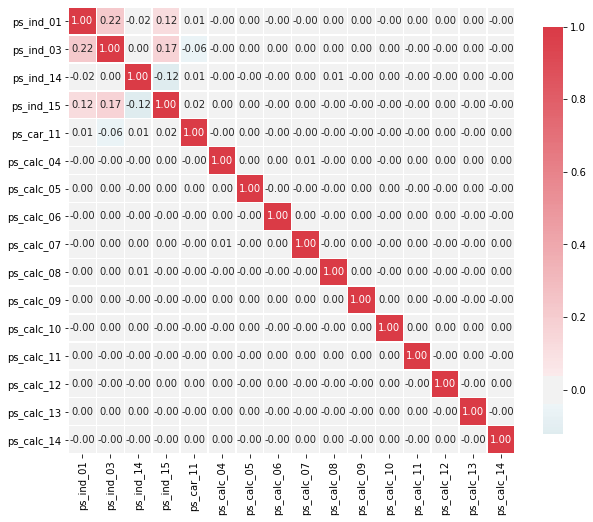

In [40]:
v = meta[(meta.level == 'ordinal') & meta.keep].index
corr_heatmap(v)

For the ordinal variables we do not see many correlations. We could, on the other hand, look at how the distributions are when grouping by the target value.

### Feature engineering

#### Creating dummy variables
The values of the categorical variables do not represent any order or magnitude. For instance, category 2 is not twice the value of category 1. Therefore we can create dummy variables to deal with that. We drop the first dummy variable as this information can be derived from the other dummy variables generated for the categories of the original variable.

In [43]:
v = meta[(meta.level == 'nominal') & (meta.keep)].index
print('Before dummification we have {} variables in train'.format(train.shape[1]))

train = pd.get_dummies(train,columns = v,drop_first = True)
print('After dummification we have {} variables in train'.format(train.shape[1]))

Before dummification we have 57 variables in train
After dummification we have 109 variables in train


So, creating dummy variables adds 52 variables to the training set.

#### Creating interaction variables

PolynomialFeature 참고자료 : https://datascienceschool.net/view-notebook/f43be7d6515b48c0beb909826993c856/

In [44]:
v = meta[(meta.level =='interval') & (meta.keep)].index
poly = PolynomialFeatures(degree = 2,interaction_only = False,include_bias = False)
interactions = pd.DataFrame(data = poly.fit_transform(train[v]),columns = poly.get_feature_names(v))
# remove the originals columns
interactions.drop(v,axis = 1,inplace = True)

# Concat the interaction variables to the train data
print('Before creating interactions we have {} variables in train'.format(train.shape[1]))
train = pd.concat([train,interactions],axis = 1)
print('After creating interactions we have {} variables in train'.format(train.shape[1]))

Before creating interactions we have 109 variables in train
After creating interactions we have 164 variables in train


This adds extra interaction variables to the train data. Thanks to the get_feature_names method we can assign column names to these new variables.

### Feature selection

#### Removing features with low or zero variance

Personally, I prefer to let the classifier algorithm chose which features to keep. But there is one thing that we can do ourselves. That is removing features with no or a very low variance. Sklearn has a handy method to do that: VarianceThreshold. By default it removes features with zero variance. This will not be applicable for this competition as we saw there are no zero-variance variables in the previous steps. But if we would remove features with less than 1% variance, we would remove 31 variables.

Low variance feature selection 참고자료 : https://community.dataquest.io/t/feature-selection-features-with-low-variance/2418

분산에 의한 선택¶<br>
원래 예측모형에서 중요한 특징데이터란 종속데이터와의 상관관계가 크고 예측에 도움이 되는 데이터를 말한다. 하지만 상관관계 계산에 앞서 특징데이터의 값 자체가 표본에 따라 그다지 변하지 않는다면 종속데이터 예측에도 도움이 되지 않을 가능성이 높다. 따라서 표본 변화에 따른 데이터 값의 변화 즉, 분산이 기준치보다 낮은 특징 데이터는 사용하지 않는 방법이 분산에 의한 선택 방법이다. 예를 들어 종속데이터와 특징데이터가 모두 0 또는 1 두가지 값만 가지는데 종속데이터는 0과 1이 균형을 이루는데 반해 특징데이터가 대부분(예를 들어 90%)의 값이 0이라면 이 특징데이터는 분류에 도움이 되지 않을 가능성이 높다.

하지만 분산에 의한 선택은 반드시 상관관계와 일치한다는 보장이 없기 때문에 신중하게 사용해야 한다.

np.vectorize는 numpy배열을 대상으로 apply,map과 유사한 기능을 한다.

In [52]:
selector = VarianceThreshold(threshold=0.1)
# Fit ti train without id and target variabels
selector.fit(train.drop(['id','target'],axis= 1))

# Function to toggle blloean array elements
f = np.vectorize(lambda x : not x)

v= train.drop(['id','target'],axis = 1).columns[f(selector.get_support())]
# get_support() : VarianceThreshold.get_support 함수로 선택한 columns의 mask를 불러온다.

print('{} variables have too low variance'.format(len(v)))
print('These variables are {}'.format(list(v)))

101 variables have too low variance
These variables are ['ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_ind_14', 'ps_reg_01', 'ps_reg_03', 'ps_car_12', 'ps_car_13', 'ps_car_14', 'ps_calc_01', 'ps_calc_02', 'ps_calc_03', 'ps_car_11_cat_te', 'ps_ind_02_cat_3', 'ps_ind_02_cat_4', 'ps_ind_05_cat_1', 'ps_ind_05_cat_2', 'ps_ind_05_cat_3', 'ps_ind_05_cat_4', 'ps_ind_05_cat_5', 'ps_ind_05_cat_6', 'ps_car_01_cat_0', 'ps_car_01_cat_1', 'ps_car_01_cat_2', 'ps_car_01_cat_3', 'ps_car_01_cat_4', 'ps_car_01_cat_5', 'ps_car_01_cat_6', 'ps_car_01_cat_8', 'ps_car_01_cat_9', 'ps_car_01_cat_10', 'ps_car_04_cat_1', 'ps_car_04_cat_2', 'ps_car_04_cat_3', 'ps_car_04_cat_4', 'ps_car_04_cat_5', 'ps_car_04_cat_6', 'ps_car_04_cat_7', 'ps_car_04_cat_8', 'ps_car_04_cat_9', 'ps_car_06_cat_2', 'ps_car_06_cat_3', 'ps_car_06_cat_4', 'ps_car_06_cat_5', 'ps_car_06_cat_6', 'ps_car_06_cat_7', 'ps_car_06_cat_8', 'ps_car_06_cat_9', 'ps_car_06_cat_10', 'ps_car_06_cat_12', 'ps_car_06_cat_13', 'ps_car_0

We would lose rather many variables if we would select based on variance. But because we do not have so many variables, we'll let the classifier chose. For data sets with many more variables this could reduce the processing time.

Sklearn also comes with other feature selection methods. One of these methods is SelectFromModel in which you let another classifier select the best features and continue with these. Below I'll show you how to do that with a Random Forest.

#### Selecting Features with a Random Forest and SelectFromModel
Here we'll base feature selection on the feature importances of a random forest. With Sklearn's SelectFromModel you can then specify how many variables you want to keep. You can set a threshold on the level of feature importance manually. But we'll simply select the top 50% best variables.

In [54]:
from tqdm.notebook import tqdm

In [57]:
X_train = train.drop(['id','target'],axis =1 )
y_train = train['target']
feat_labels = X_train.columns


In [59]:
rf = RandomForestClassifier(n_estimators = 1000,random_state = 0,n_jobs = 2,verbose=1)
rf.fit(X_train,y_train)
importances = rf.feature_importances_
indices = np.argsort(rf.feature_importances_)[::-1]

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  1.1min
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:  4.9min
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed: 11.2min
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed: 20.0min
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed: 25.1min finished


In [60]:
for f in tqdm(range(X_train.shape[1])):
    print("%2d) % -*s %f" % (f +1,30,feat_labels[indices[f]],importances[indices[f]]))

 1) ps_car_11_cat_te               0.021096
 2) ps_car_13                      0.017387
 3) ps_car_12 ps_car_13            0.017307
 4) ps_car_13^2                    0.017229
 5) ps_car_13 ps_car_14            0.017144
 6) ps_reg_03 ps_car_13            0.017115
 7) ps_car_13 ps_car_15            0.016797
 8) ps_reg_01 ps_car_13            0.016753
 9) ps_reg_03 ps_car_14            0.016232
10) ps_reg_03 ps_car_12            0.015575
11) ps_reg_03 ps_car_15            0.015176
12) ps_car_14 ps_car_15            0.014992
13) ps_car_13 ps_calc_03           0.014753
14) ps_reg_02 ps_car_13            0.014727
15) ps_reg_01 ps_reg_03            0.014720
16) ps_car_13 ps_calc_01           0.014698
17) ps_car_13 ps_calc_02           0.014594
18) ps_reg_01 ps_car_14            0.014329
19) ps_reg_03                      0.014260
20) ps_reg_03^2                    0.014204
21) ps_reg_03 ps_calc_03           0.013871
22) ps_reg_03 ps_calc_02           0.013756
23) ps_reg_03 ps_calc_01        

With SelectFromModel we can specify which prefit classifier to use and what the threshold is for the feature importances. With the get_support method we can then limit the number of variables in the train data.

SelectFromModel참고자료 : https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html

In [61]:
sfm = SelectFromModel(rf,threshold='median',prefit = True)
print('Number of features before selection {}'.format(X_train.shape[1]))
n_features = sfm.transform(X_train).shape[1]
print('Number of features after selection : {}'.format(n_features))
selected_vars = list(feat_labels[sfm.get_support()])

Number of features before selection 162
Number of features after selection : 81


In [62]:
train = train[selected_vars + ['target']]

### Feature Scaling
As mentioned before, we can apply standard scaling to the training data.Some classifiers perform better when this is done

스케일링의 목적은 여러가지 feature의 중심값과 분산을 통일시키는 것입니다. 이 목표만 달성한다면 방법은 어떤 것을 써도 무방합니다.

In [80]:
scaler = StandardScaler()
Test = scaler.fit_transform(train.drop(['target'],axis = 1)) # 행방향으로 표준화가 진행된다.

In [84]:
Test[0]

array([-4.59411042e-01, -1.26665356e+00,  1.05087653e+00, -4.52181905e-02,
        3.79365552e-01, -1.92498055e-01, -1.61133377e+00, -2.03898341e-01,
       -1.21861268e+00, -6.55641543e-01, -1.46709593e+00,  1.56691700e+00,
       -5.22682099e-01, -1.56889417e+00,  5.62577003e-01, -1.66001241e+00,
       -5.17288669e-01,  8.59293890e-04, -8.38255155e-01,  1.33670669e+00,
       -1.48492695e-01, -1.90476325e+00, -1.19762322e+00,  6.65938794e-01,
       -5.60892078e-01, -2.01081820e-01, -3.20859003e-01,  8.82581715e-02,
       -1.60083410e-01, -1.06477934e-01, -6.26754098e-01, -1.99818582e-01,
       -6.76227460e-01,  1.13328985e+00, -4.11090026e-01, -1.18263273e+00,
       -8.12389778e-03,  1.94303454e-02,  2.78402376e-01, -1.37067239e-01,
        2.51059301e-01, -1.34216833e-01,  1.34838503e+00, -7.97327721e-02,
       -7.92102036e-01, -2.93119742e-01, -2.51317179e-01, -7.38037972e-01,
       -3.70975980e-01, -8.97577299e-01,  1.13636074e+00, -4.96611276e-01,
       -1.31479517e+00, -

In [82]:
pd.DataFrame(Test)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80
0,-0.459411,-1.266654,1.050877,-0.045218,0.379366,-0.192498,-1.611334,-0.203898,-1.218613,-0.655642,-1.467096,1.566917,-0.522682,-1.568894,0.562577,-1.660012,-0.517289,0.000859,-0.838255,1.336707,-0.148493,-1.904763,-1.197623,0.665939,-0.560892,-0.201082,-0.320859,0.088258,-0.160083,-0.106478,-0.626754,-0.199819,-0.676227,1.133290,-0.411090,-1.182633,-0.008124,0.019430,0.278402,-0.137067,0.251059,-0.134217,1.348385,-0.079733,-0.792102,-0.293120,-0.251317,-0.738038,-0.370976,-0.897577,1.136361,-0.496611,-1.314795,-0.252648,-0.871261,-0.456482,-1.284574,1.412013,-0.533955,-1.507913,-0.907201,-1.078018,-1.414788,0.449983,-0.779056,-1.393891,-0.657991,-1.500506,1.295764,-0.589610,-1.532634,-1.744045,0.434042,-0.812245,-1.435052,1.956864,0.336293,-1.009825,-0.725536,-1.010719,-1.061738
1,1.555390,0.950343,-0.638473,0.999101,0.379366,-0.540382,-1.611334,0.742076,-1.913216,0.093092,-4.206577,-0.869579,-1.569194,0.521864,-1.227707,-0.778680,-0.517289,1.413096,0.532277,1.336707,0.884019,-1.047321,-1.197623,0.075222,-0.197534,0.840542,1.148280,0.585660,0.243818,1.267577,-0.555376,0.999838,-1.864492,-0.409026,-1.182972,1.132241,-0.008124,-0.083950,0.472818,-0.363425,0.376732,-1.017747,-0.317136,-0.793786,0.631925,-0.538984,-0.251619,-1.168339,-0.477224,-2.262245,-0.839629,-1.313307,0.105257,0.643604,-1.137455,0.453191,-3.468466,-0.759498,-1.508479,0.731446,-1.216501,-1.442461,-2.424081,-1.101077,-1.394129,-0.523489,0.032995,-3.757638,-0.842423,-1.533498,0.532133,-2.913661,-1.432241,-1.435261,-1.435052,-0.912576,-1.010512,-0.411445,-1.061209,-1.010719,0.279079
2,1.051689,-0.527655,-0.920031,0.999101,0.379366,-0.093839,0.784868,0.328373,-0.012842,0.625472,0.336338,-0.521508,1.570343,-1.220434,1.457719,-0.778680,0.232023,1.413096,0.532277,-0.270456,-0.148493,0.667563,0.466236,0.075222,0.892541,-0.153086,1.148280,0.585660,0.579055,1.080702,0.809850,1.190305,1.091279,-0.023447,2.290497,-0.796820,-0.008124,0.048749,0.387794,0.255869,0.466089,0.447422,-0.079205,1.348374,-0.554764,-0.217125,0.010924,-0.108682,0.091311,0.084810,-0.465981,1.227733,-1.032364,0.236217,0.040382,0.459488,0.459684,-0.450564,1.662581,-1.156032,-0.119533,0.148844,0.096924,-0.466617,1.385190,-1.085436,0.562751,0.599113,-0.434079,1.762457,-1.167109,0.302784,-0.400615,1.664204,-1.090865,-0.726249,0.336293,-0.860230,1.959845,-0.562153,-1.024493
3,2.059090,0.580843,0.206202,-0.045218,2.582369,2.558927,-0.413233,0.328373,0.093412,0.084138,0.732093,1.218846,-0.173845,-1.220434,0.562577,0.983986,-0.517289,-0.705259,1.217543,0.533125,0.539848,-1.476042,0.466236,-1.696930,2.345973,-0.587455,-0.320859,1.580463,1.216982,0.053811,0.001617,-0.023374,0.277682,0.876237,-0.153796,-0.925425,3.100569,3.248203,2.490252,2.096152,2.528656,2.964269,3.965633,1.586392,-0.198757,2.864666,2.283757,1.676178,2.369144,2.744921,3.117905,0.902962,-0.760545,0.236217,0.109986,0.197263,0.801883,1.307384,-0.099119,-1.156032,-0.034867,0.058404,0.397708,1.146779,-0.122292,-1.076300,0.024358,0.696730,1.219589,-0.155823,-1.188866,0.887592,1.558416,0.062283,-1.060882,1.323351,0.585701,-0.610905,-0.464457,-0.811356,-1.024493
4,1.555390,0.211344,0.769318,0.650994,0.868922,0.595187,0.784868,0.328373,0.390330,0.229242,0.732093,0.522705,0.174993,1.567243,0.562577,0.983986,-2.015911,-0.705259,-0.152989,-1.074037,-0.836833,-0.189879,-0.365694,1.847373,0.165824,0.295515,0.593272,0.861994,0.808938,0.738405,0.780933,0.702777,0.991740,0.876237,0.532321,1.903865,0.452423,0.594792,0.855007,0.820766,0.886242,1.105995,1.110453,0.792999,2.055953,0.390829,0.601267,0.574185,0.617983,0.927100,0.803924,0.451275,1.862501,0.236217,0.304490,0.267553,0.801883,0.604205,0.253221,1.659019,0.214825,0.331365,0.624526,0.665352,0.323456,1.694178,0.165434,0.772299,0.567006,0.217811,1.613765,0.887592,0.810752,0.43

In [77]:
DD= train.ps_ind_01.values

In [116]:
Mean = train.ps_ind_01.mean()

In [113]:
Std=train.ps_ind_01.std()

In [118]:
# [내 생각]자체에 연산작업 넣어버리면 한 데이터마다 그 작업이 계속 진행되므로 시간이 오래 걸린다. 주의!!
train.ps_ind_01.apply(lambda x : ((x - Mean))/Std) 

0        -0.459410
1         1.555386
2         1.051687
3         2.059085
4         1.555386
            ...   
216935    1.555386
216936   -0.459410
216937   -0.963109
216938   -0.963109
216939   -0.459410
Name: ps_ind_01, Length: 216940, dtype: float64